<a href="https://colab.research.google.com/github/TaisiaKozharina/WSI_artifact_segmentation/blob/main/bach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install imagecodecs

In [2]:
!nvidia-smi

Mon May  6 18:08:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# NN related
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.v2 import ToTensor
from torch.utils.data import DataLoader

# Data preprocessing
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as F
from glob import glob
from tifffile import imread
from PIL import Image
from pathlib import Path
from skimage import measure
from skimage import color

# Other
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm # progress bar

print("Torch version: ", torch.__version__)
print("TorchVision version: ", torchvision.__version__)

Torch version:  2.2.1+cu121
TorchVision version:  0.17.1+cu121


In [4]:
! python3 --version

Python 3.10.12


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. READING DATA 💜

### 1.0. Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) # force_remount=True

# PATHS
bin_map_dir = '/content/drive/MyDrive/pathdata/bin_maps/*.tif'
originals_dir = '/content/drive/MyDrive/pathdata/component_data/*.tif'

Mounted at /content/drive


In [7]:
!ls "/content/drive/MyDrive/pathdata/"

bin_maps  bin_maps_old	component_data	seg_final_FAILED


### 1.1. Define custom class for data samples

🔴 TODO: Add methods for segment extraction and plot creation

1.1.1 Helper function

In [8]:
# CONSTANTS
tint_c0 = (torch.Tensor([[0],[0], [100]])/1000)
tint_c6 = (torch.Tensor([[79], [0], [66]]) / 1000)
tint_c7 = (torch.Tensor([[36], [69], [69]]) / 1000)
DOWNSAMPLE_HEIGHT = 500
ALPHA = 0.5

def color_WSI(path):

  original = F.resize(torch.Tensor(imread(path)), [DOWNSAMPLE_HEIGHT])

  rbg_c0 = original[0].repeat(3,1,1)
  rbg_c6 = original[6].repeat(3,1,1)
  rbg_c7 = original[7].repeat(3,1,1)

  tinted_c0 = rbg_c0*torch.unsqueeze(tint_c0,1)
  tinted_c6 = rbg_c6*torch.unsqueeze(tint_c6,1)
  tinted_c7 = rbg_c7*torch.unsqueeze(tint_c7,1)

  out = torch.Tensor(((tinted_c0 * (1.0 - ALPHA) + tinted_c6 * ALPHA)*ALPHA + tinted_c7 * (1.0 - ALPHA))*2)

  return out

def extract_segmets(annotation, original):

  segments = []

  for channel in annotation:
    labeled = torch.Tensor(measure.label(channel, connectivity=2))
    labels = torch.unique(labeled)

    for label in labels[labels != 0]:

      mask = F.resize(torch.where(labeled == label, 1, 0).repeat(3,1,1), [DOWNSAMPLE_HEIGHT])
      masked_original = original * mask
      segments.append(masked_original)

  return segments

1.1.2. Dataset class

In [19]:
class WSI_Dataset(Dataset):
    """
    Whole-Slide Image dataset

    Arguments:
          annotations_path (string): Path to the root folder on GDrive of annotations.
          images_path (string): Path to the root folder on GDrive of original WSI images.
          transform (callable, optional): Optional transform to be applied on a sample.

      __getitem___(self, index):
        Returns sample elements by index. Index is taken in respect to unordered dataset stored on google drive.
        * id: string, ID of sample
        * original: torch.tensor, RBG combination of 3 channels,
        * annotation: torch.tensor, Grayscale annotation map,
        * segments: list of RBG separated annotated segments

    """

    def __init__(self, annotations_path, images_path, transform=None):

      self.annotations_path = annotations_path
      self.images_path = images_path
      self.transform = transform
      self.cache = {}  # Dictionary to cache samples

    def __len__(self):
      return len(glob(self.annotations_path))

    def __getitem__(self, index):

      if index in self.cache:  # Check if sample is already cached
        return self.cache[index]

      if torch.is_tensor(index):
          index = index.tolist()

      annotation_path = sorted(glob(self.annotations_path))[index]
      ID = Path(annotation_path).name.replace("_binary_map.tif","")
      original_path = self.images_path.replace("*.tif", f"{ID}_component_data.tif")

      #print(f"Provided Index: {index} \nID: {ID} \nMap path: {annotation_path}\nOriginals path: {original_path} \nImages path: {self.images_path} \nBin path: {self.annotations_path}")

      if original_path in glob(self.images_path):
        original = color_WSI(original_path)
        annotation = torch.Tensor(imread(annotation_path).astype(np.float32))
        segments = extract_segmets(annotation, original)

      else:
        print(f"Corresponding original image file not found for sample: {ID}")
        original = torch.Tensor([])
        annotation = torch.Tensor([])
        segments = []

      sample = {
          'id': ID,
          'original': original,
          'annotation': annotation,
          'segments': segments
      }

      if self.transform:
          sample = self.transform(sample)

      self.cache[index] = sample  # Cache the sample

      return sample


In [20]:
wsi_samples = WSI_Dataset(bin_map_dir, originals_dir)

print(f"\n🔊 TOTAL SAMPLE SIZE: {len(wsi_samples)}")
#print(f"\n🔊 SAMPLE SHAPE: {wsi_samples[0]['original'].shape}")
print(f"\n🔊 SAMPLE SHAPE: {wsi_samples[0]['original'].shape[0]} channel(s) or dimensions [{wsi_samples[0]['original'].shape[1]} x {wsi_samples[0]['original'].shape[2]}]")
print(f"\n🔊 Sample {wsi_samples[0]['id']} has {len(wsi_samples[0]['segments'])} segments")


🔊 TOTAL SAMPLE SIZE: 117
Provided Index: 0 
ID: BOMI2_TIL_1_Core[1,1,A]_[5091,35249] 
Map path: /content/drive/MyDrive/pathdata/bin_maps/BOMI2_TIL_1_Core[1,1,A]_[5091,35249]_binary_map.tif
Originals path: /content/drive/MyDrive/pathdata/component_data/BOMI2_TIL_1_Core[1,1,A]_[5091,35249]_component_data.tif 
Images path: /content/drive/MyDrive/pathdata/component_data/*.tif 
Bin path: /content/drive/MyDrive/pathdata/bin_maps/*.tif

🔊 SAMPLE SHAPE: 3 channel(s) or dimensions [500 x 668]

🔊 Sample BOMI2_TIL_1_Core[1,1,A]_[5091,35249] has 27 segments


### 1.4. Exploration of data

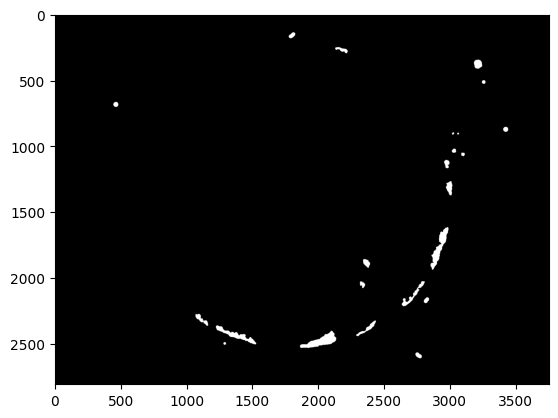

In [21]:
plt.imshow(wsi_samples[0]['annotation'][0], cmap="gray")

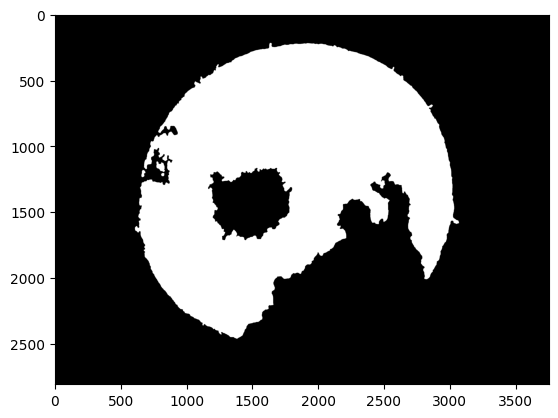

In [22]:
plt.imshow(wsi_samples[0]['annotation'][1], cmap="gray")

In [23]:
wsi_samples[0]['original'].shape[0]

3

In [ ]:
labeled = measure.label(wsi_samples[1]['annotation'][0], connectivity=2)
plt.imshow(labeled, cmap="gray")

In [ ]:
print(np.unique(labeled))

[0 1 2 3 4 5]


In [ ]:
original = torch.Tensor(imread(originals_dir.replace("*.tif", f"{wsi_samples[2]['id']}_component_data.tif"))).to("cpu")

print(original[0].shape)
print(torch.unique(original[0]))

print(original[6].shape)
print(torch.unique(original[6]))

print(original[7].shape)
print(torch.unique(original[7]))


torch.Size([2808, 3752])
tensor([0.0000e+00, 1.3552e-06, 2.1820e-06,  ..., 2.5206e+01, 2.5652e+01,
        2.7066e+01])
torch.Size([2808, 3752])
tensor([0.0000e+00, 1.5205e-07, 4.4957e-07,  ..., 5.6580e+01, 5.6819e+01,
        5.6946e+01])
torch.Size([2808, 3752])
tensor([0.0000e+00, 1.1697e-02, 2.1467e-02,  ..., 2.3245e+01, 2.3267e+01,
        2.6116e+01])


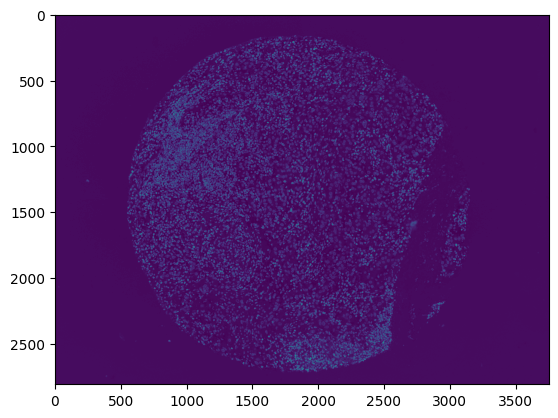

In [ ]:
plt.imshow(original[0])

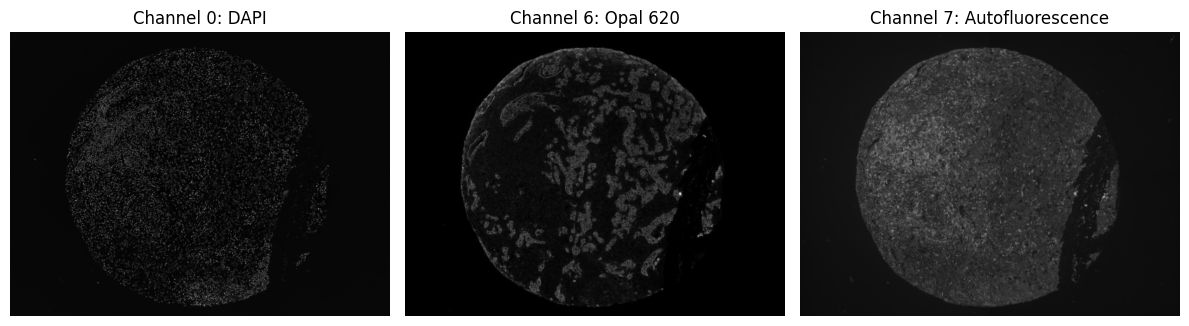

In [ ]:
fig,axes = plt.subplots(1, 3, figsize=(12, 18))

axes[0].imshow(original[0], cmap="gray")
axes[0].set_title(f"Channel 0: DAPI")
axes[0].axis('off')

axes[1].imshow(original[6], cmap="gray")
axes[1].set_title(f"Channel 6: Opal 620")
axes[1].axis('off')  # Turn off axis

axes[2].imshow(original[7], cmap="gray")
axes[2].set_title(f"Channel 7: Autofluorescence")
axes[2].axis('off')

plt.tight_layout()
plt.show()

torch.Size([3, 2808, 3752])
torch.Size([3, 1])
tensor([[0.0000],
        [0.0000],
        [0.1000]])
torch.Size([3, 2808, 3752])


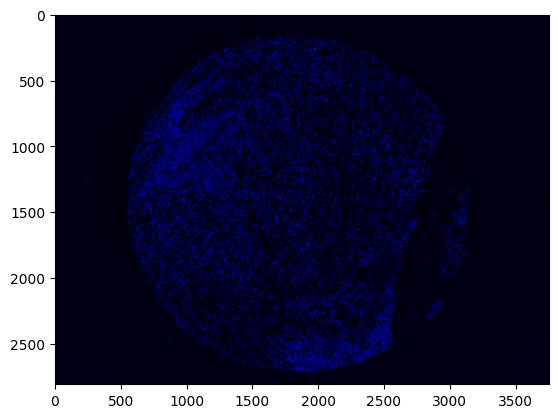

In [ ]:
image_rgb = original[0].repeat(3,1,1)
print(image_rgb.shape)

tint_c0 = torch.Tensor([[0],[0], [100]])/1000
print(tint_c0.shape)
print(tint_c0)

# Apply tint to grayscale image
color_channel_0 = image_rgb * torch.unsqueeze(tint_c0,1)
print(color_channel_0.shape)

# Display the tinted image
plt.imshow(color_channel_0.permute(1, 2, 0))

tensor([[0.0790],
        [0.0000],
        [0.0660]])


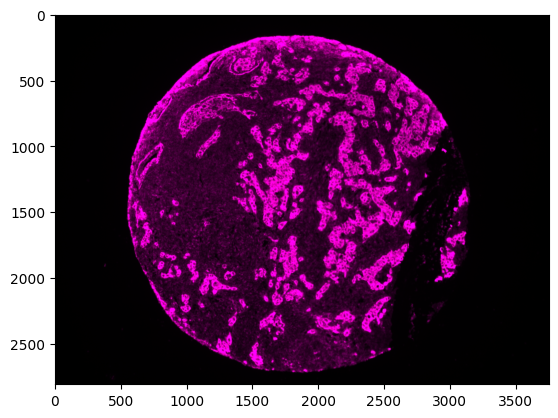

In [ ]:
image_rgb = original[6].repeat(3,1,1)

tint_c6 = torch.Tensor([[79], [0], [66]])/1000
print(tint_c6)

color_channel_6 = image_rgb * torch.unsqueeze(tint_c6,1)
plt.imshow(color_channel_6.permute(1, 2, 0))


tensor([[0.0360],
        [0.0690],
        [0.0690]])


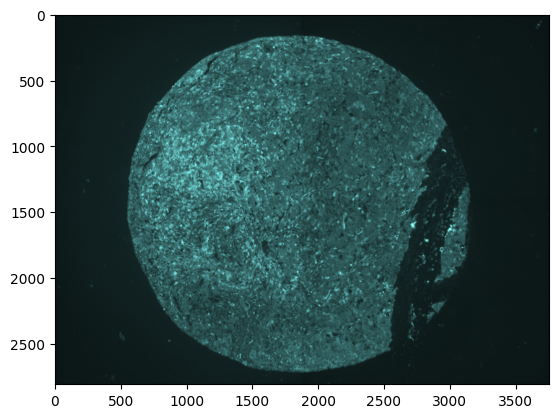

In [ ]:
image_rgb = original[7].repeat(3,1,1)

tint_c7 = torch.Tensor([[36], [69], [69]])/1000
print(tint_c7)

color_channel_7 = image_rgb * torch.unsqueeze(tint_c7,1)
plt.imshow(color_channel_7.permute(1, 2, 0))

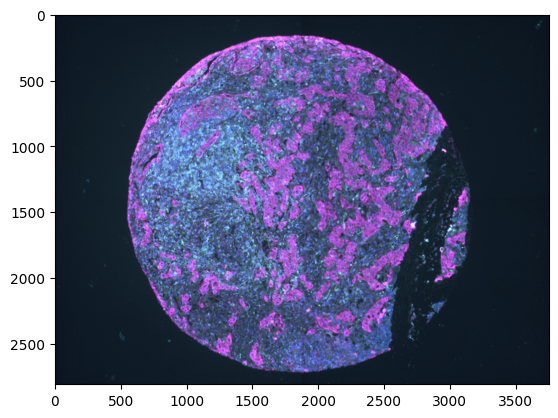

In [ ]:

alpha = 0.5
out = ((color_channel_0 * (1.0 - alpha) + color_channel_6 * alpha)*alpha + color_channel_7 * (1.0 - alpha))*2

plt.imshow(out.permute(1, 2, 0))

# 2. CLUSTERIZATION 💚

## 2.1. Preparing pipeline

For each sample there is a corresponding mask with several (2 for now) channels with purpose of storing layered annotations. All annotated segments per channel are marked with one class. Algorithm includes individual labeling using ```skimage.measure.label()``` which assigns a color class to each instance. Then for each instance masked image is stored in samples collection with original size

```
From skimage docs:

  1-connectivity     2-connectivity     diagonal connection close-up

      [ ]           [ ]  [ ]  [ ]             [ ]
        |               \  |  /                 |  <- hop 2
  [ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
        |               /  |  \             hop 1
      [ ]           [ ]  [ ]  [ ]

```

In [ ]:
! PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

## 2.2 Extracting segments

In [ ]:
wsi_samples[13]['id']

NameError: name 'wsi_samples' is not defined

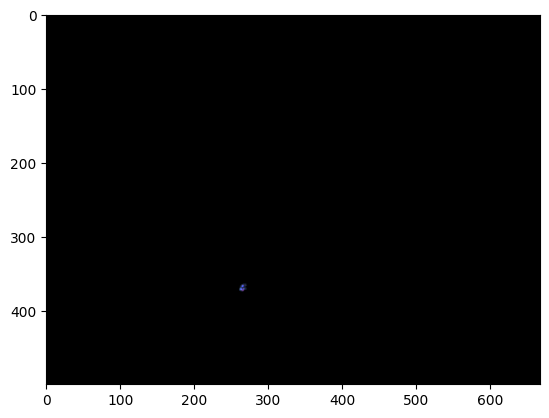

In [ ]:
plt.imshow(wsi_samples[13]['segments'][5].permute(1, 2, 0))

Size of new segment: torch.Size([3, 244, 244])


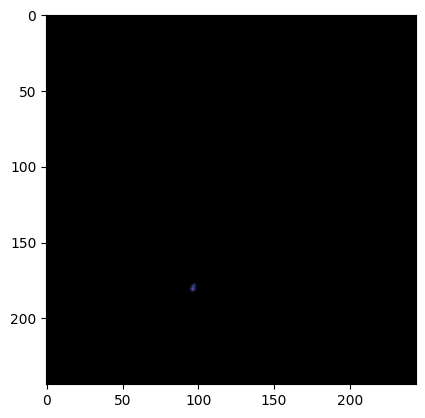

In [ ]:
right_size = F.resize(wsi_samples[13]['segments'][5], [244,244])
print(f"Size of new segment: {right_size.shape}")
plt.imshow(right_size.cpu().permute(1, 2, 0))

torch.Size([3, 244, 244])
torch.Size([244, 244])


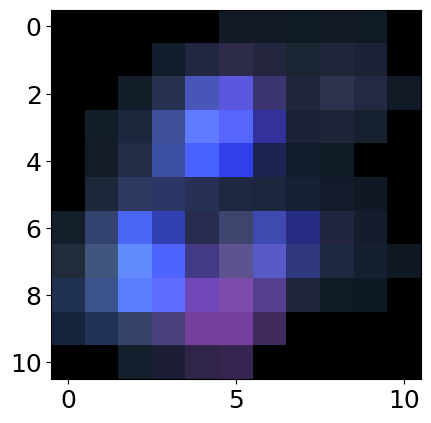

In [ ]:
print(right_size.shape)

print(right_size.sum(dim=0).shape)

non_zero_indices = torch.nonzero(wsi_samples[13]['segments'][5].sum(dim=0))
if non_zero_indices.numel() > 0:
    min_x = torch.min(non_zero_indices[:, 0]).item()
    max_x = torch.max(non_zero_indices[:, 0]).item()
    min_y = torch.min(non_zero_indices[:, 1]).item()
    max_y = torch.max(non_zero_indices[:, 1]).item()
else:
    # Handle the case when there are no non-zero indices
    min_x = max_x = min_y = max_y = 0  # or any other appropriate value

# Crop the segment based on the bounding box
cropped_segment = wsi_samples[13]['segments'][5][:, min_x:max_x+1, min_y:max_y+1]

plt.imshow(cropped_segment.cpu().permute(1, 2, 0))

In [ ]:
import os
from torchvision.transforms import ToPILImage
output_path = '/content/drive/MyDrive/pathdata/seg_final'

#[preprocess(segment) for sample in tqdm(wsi_samples) for segment in sample['segments']]
for i, sample in tqdm(enumerate(wsi_samples)):

    for j, segment in enumerate(sample['segments']):

      # Cropping segment as bounding box
      non_zero_indices = torch.nonzero(segment.sum(dim=0))
      if non_zero_indices.numel() > 0:
          min_x = torch.min(non_zero_indices[:, 0]).item()
          max_x = torch.max(non_zero_indices[:, 0]).item()
          min_y = torch.min(non_zero_indices[:, 1]).item()
          max_y = torch.max(non_zero_indices[:, 1]).item()
      else:
          # Handle the case when there are no non-zero indices
          min_x = max_x = min_y = max_y = 0  # or any other appropriate value

      # Crop the segment based on the bounding box
      cropped_segment = segment[:, min_x:max_x+1, min_y:max_y+1]

      image = ToPILImage()(cropped_segment)

      # Save image to Google Drive
      image_path = os.path.join(output_path, f'{sample["id"]}_seg_{j}.png')
      image.save(image_path)

      print(f'Saved image {i+1}/{len(wsi_samples)} to {image_path}')

0it [00:00, ?it/s]

Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_0.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_1.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_2.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_3.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_4.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_5.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_6.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_7.png
Saved image 1/66 to /content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,1,C]_[8663,35138]_seg_8.png
Saved image 1/66 to

## 2.2. VGG16

In [ ]:
! pip install clustimage
! pip install -U clustimage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
from clustimage import Clustimage

# Perform clustering using clustimage
n_clusters = 10  # Number of clusters
cl = Clustimage(method="pca-hog", dim=(224,224))
cl.clean_init()
results = cl.fit_transform('/content/drive/MyDrive/pathdata/seg_final', min_clust=5, max_clust=20)

[clustimage] >WARNING> Parameter grayscale is set to True because you are using method="pca-hog"
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Extracting images from: [/content/drive/MyDrive/pathdata/seg_final]
[clustimage] >INFO> [1909] files are collected recursively from path: [/content/drive/MyDrive/pathdata/seg_final]
[clustimage] >INFO> [1909] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
[clustimage]: 100%|██████████| 1909/1909 [00:04<00:00, 384.61it/s]
[clustimage] >INFO> Extracting features using method: [pca-hog]
[clustimage]: 100%|██████████| 1909/1909 [10:43<00:00,  2.97it/s]
[clustimage] >INFO> Extracted features using [pca-hog]: samples=1909

[clustimage] >INFO> Create scatterplot


[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '182 Principal Components explain [95.03%] of the variance'}, xlabel='PC1 (38.9% expl.var)', ylabel='PC2 (7.37% expl.var)'>)

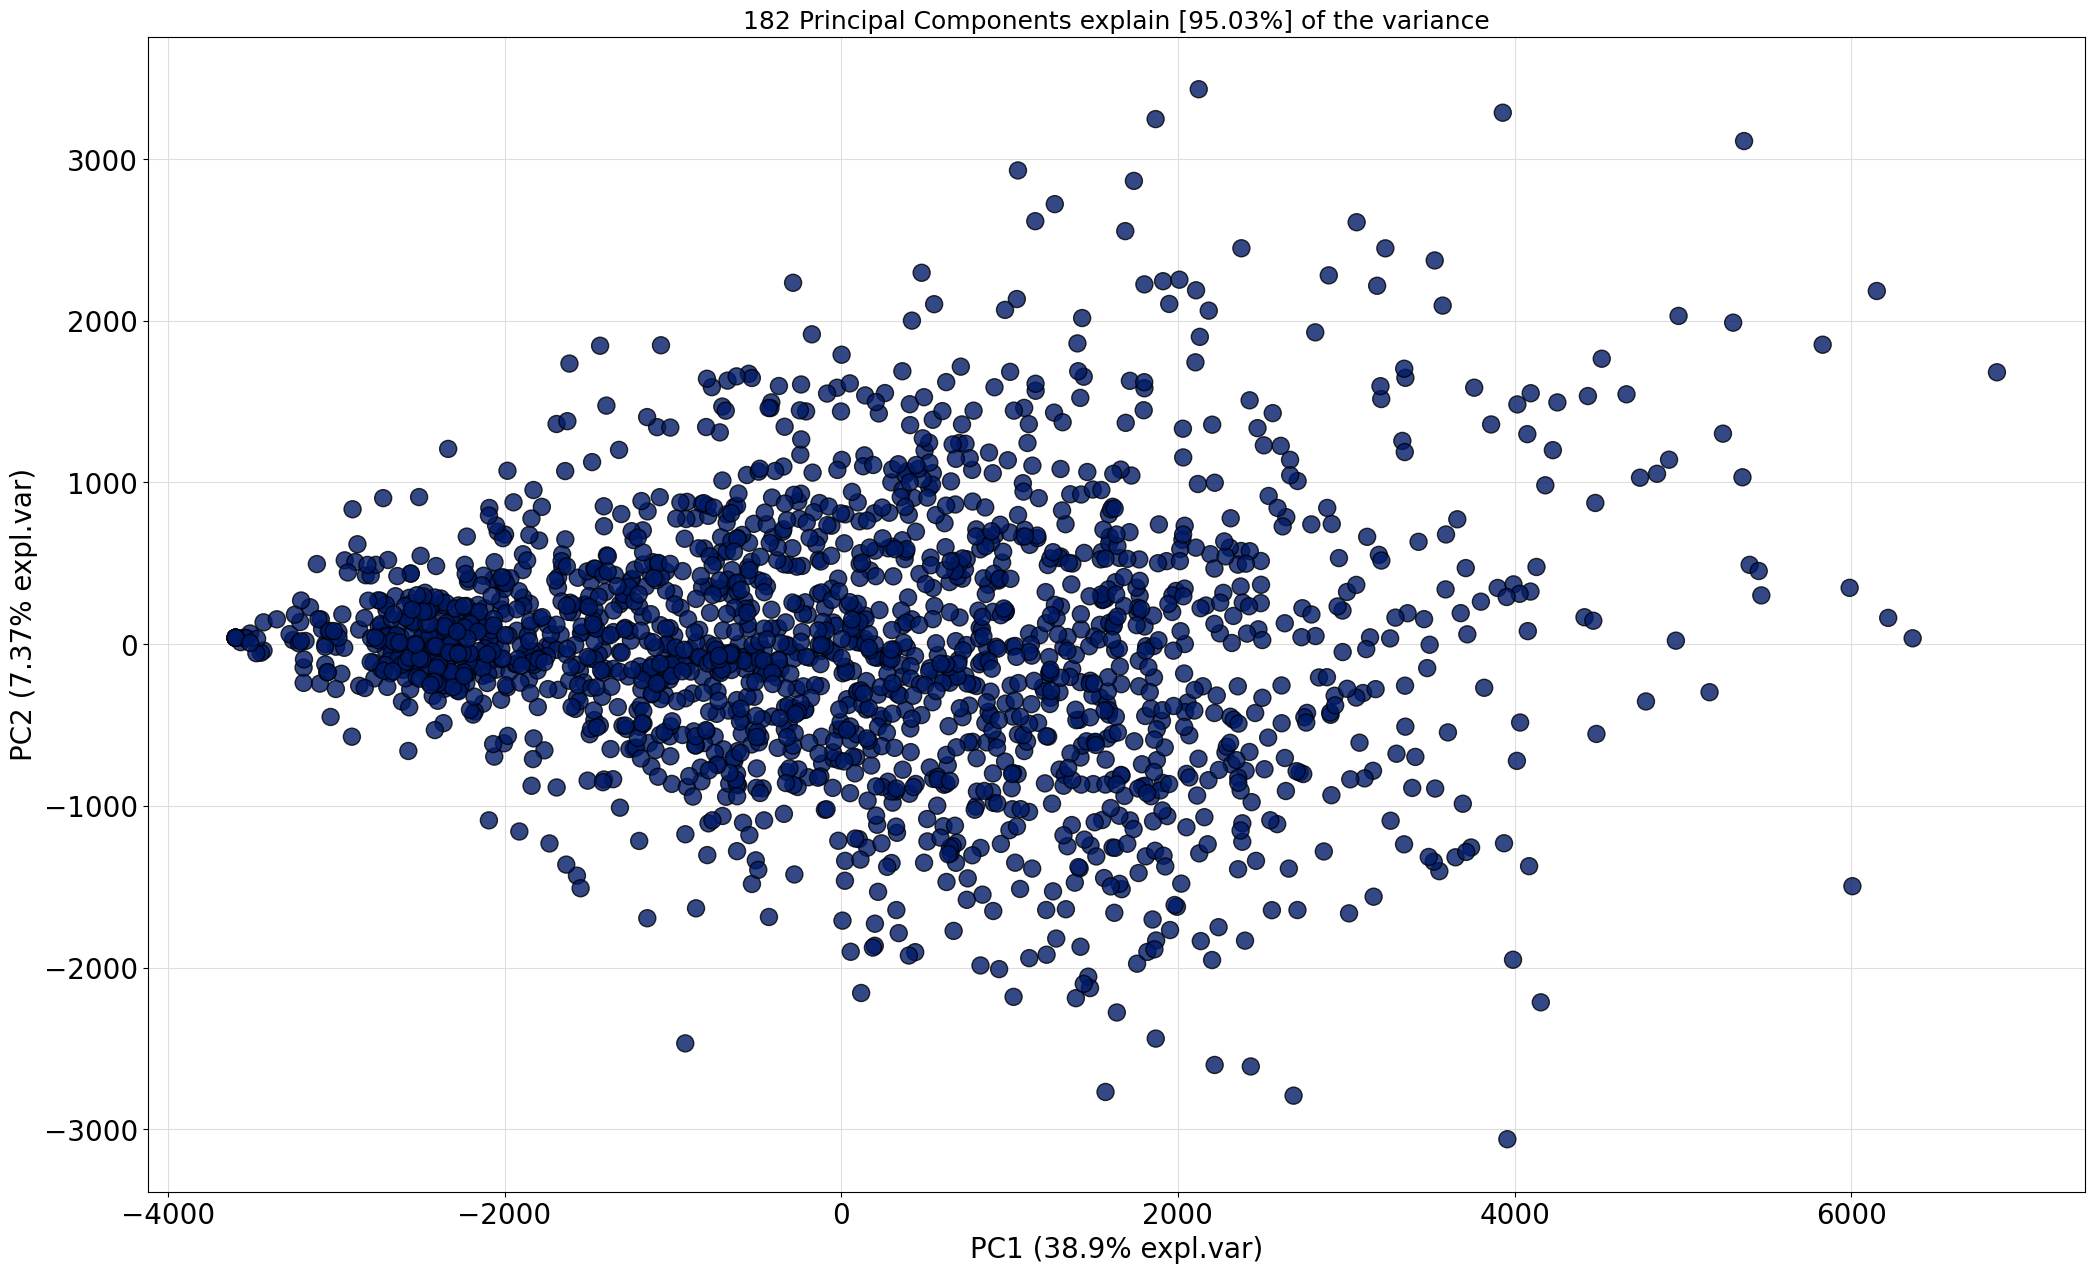

In [ ]:
cl.pca.scatter(legend=False, label=False)

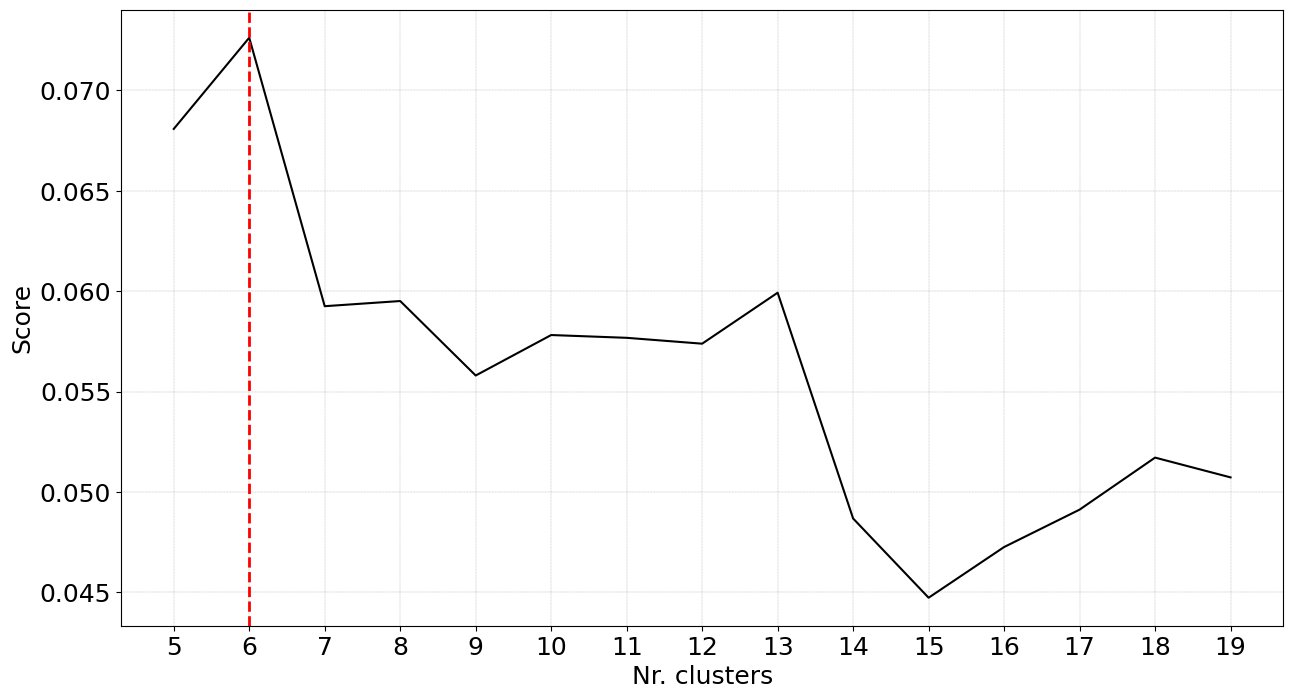

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [ ]:
cl.clusteval.plot()

[clustimage] >INFO> Coordinates (x, y) are set based on the first two features.
[clustimage] >INFO> Set alpha based on density because of the parameter: [opaque]
[clustimage] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

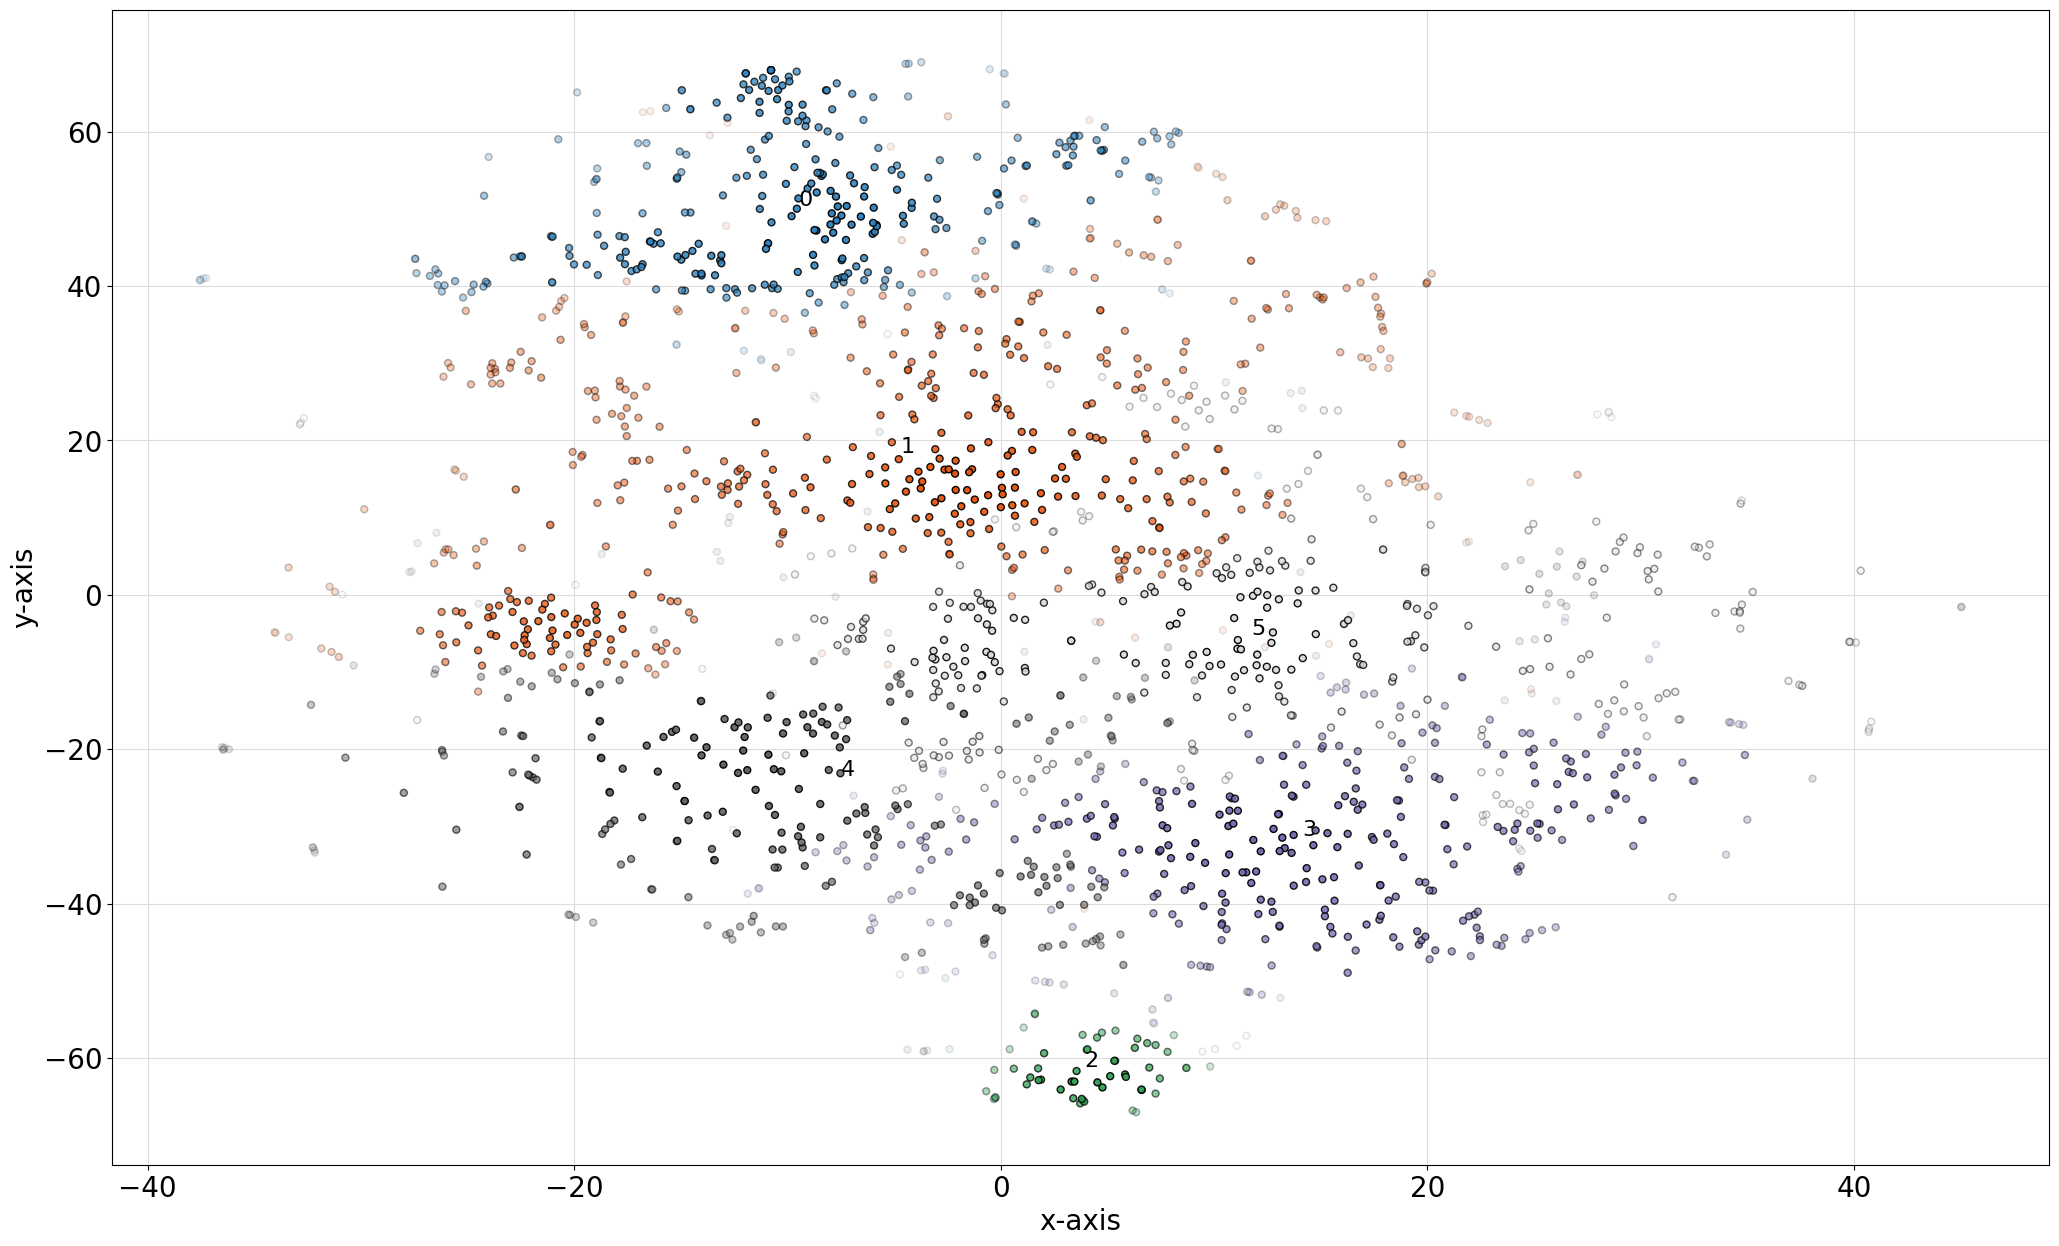

In [ ]:
cl.clusteval.scatter(cl.results['xycoord'])

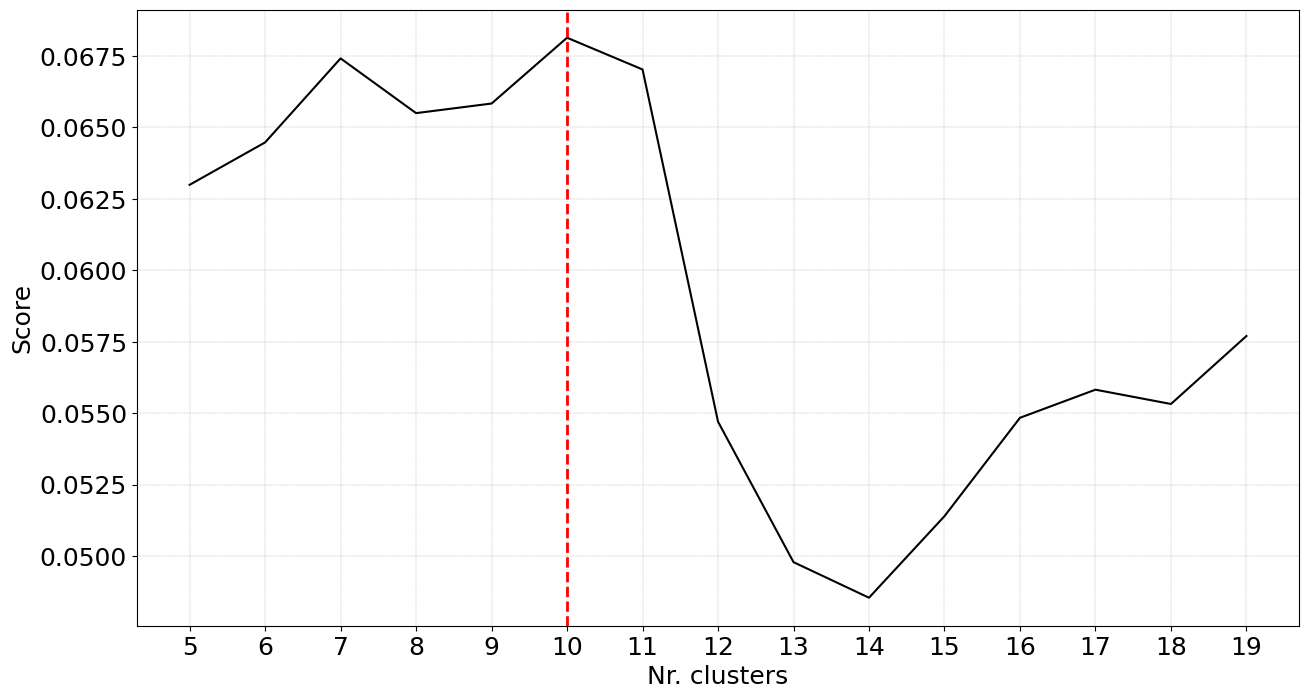

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [ ]:
cl.clusteval.plot()

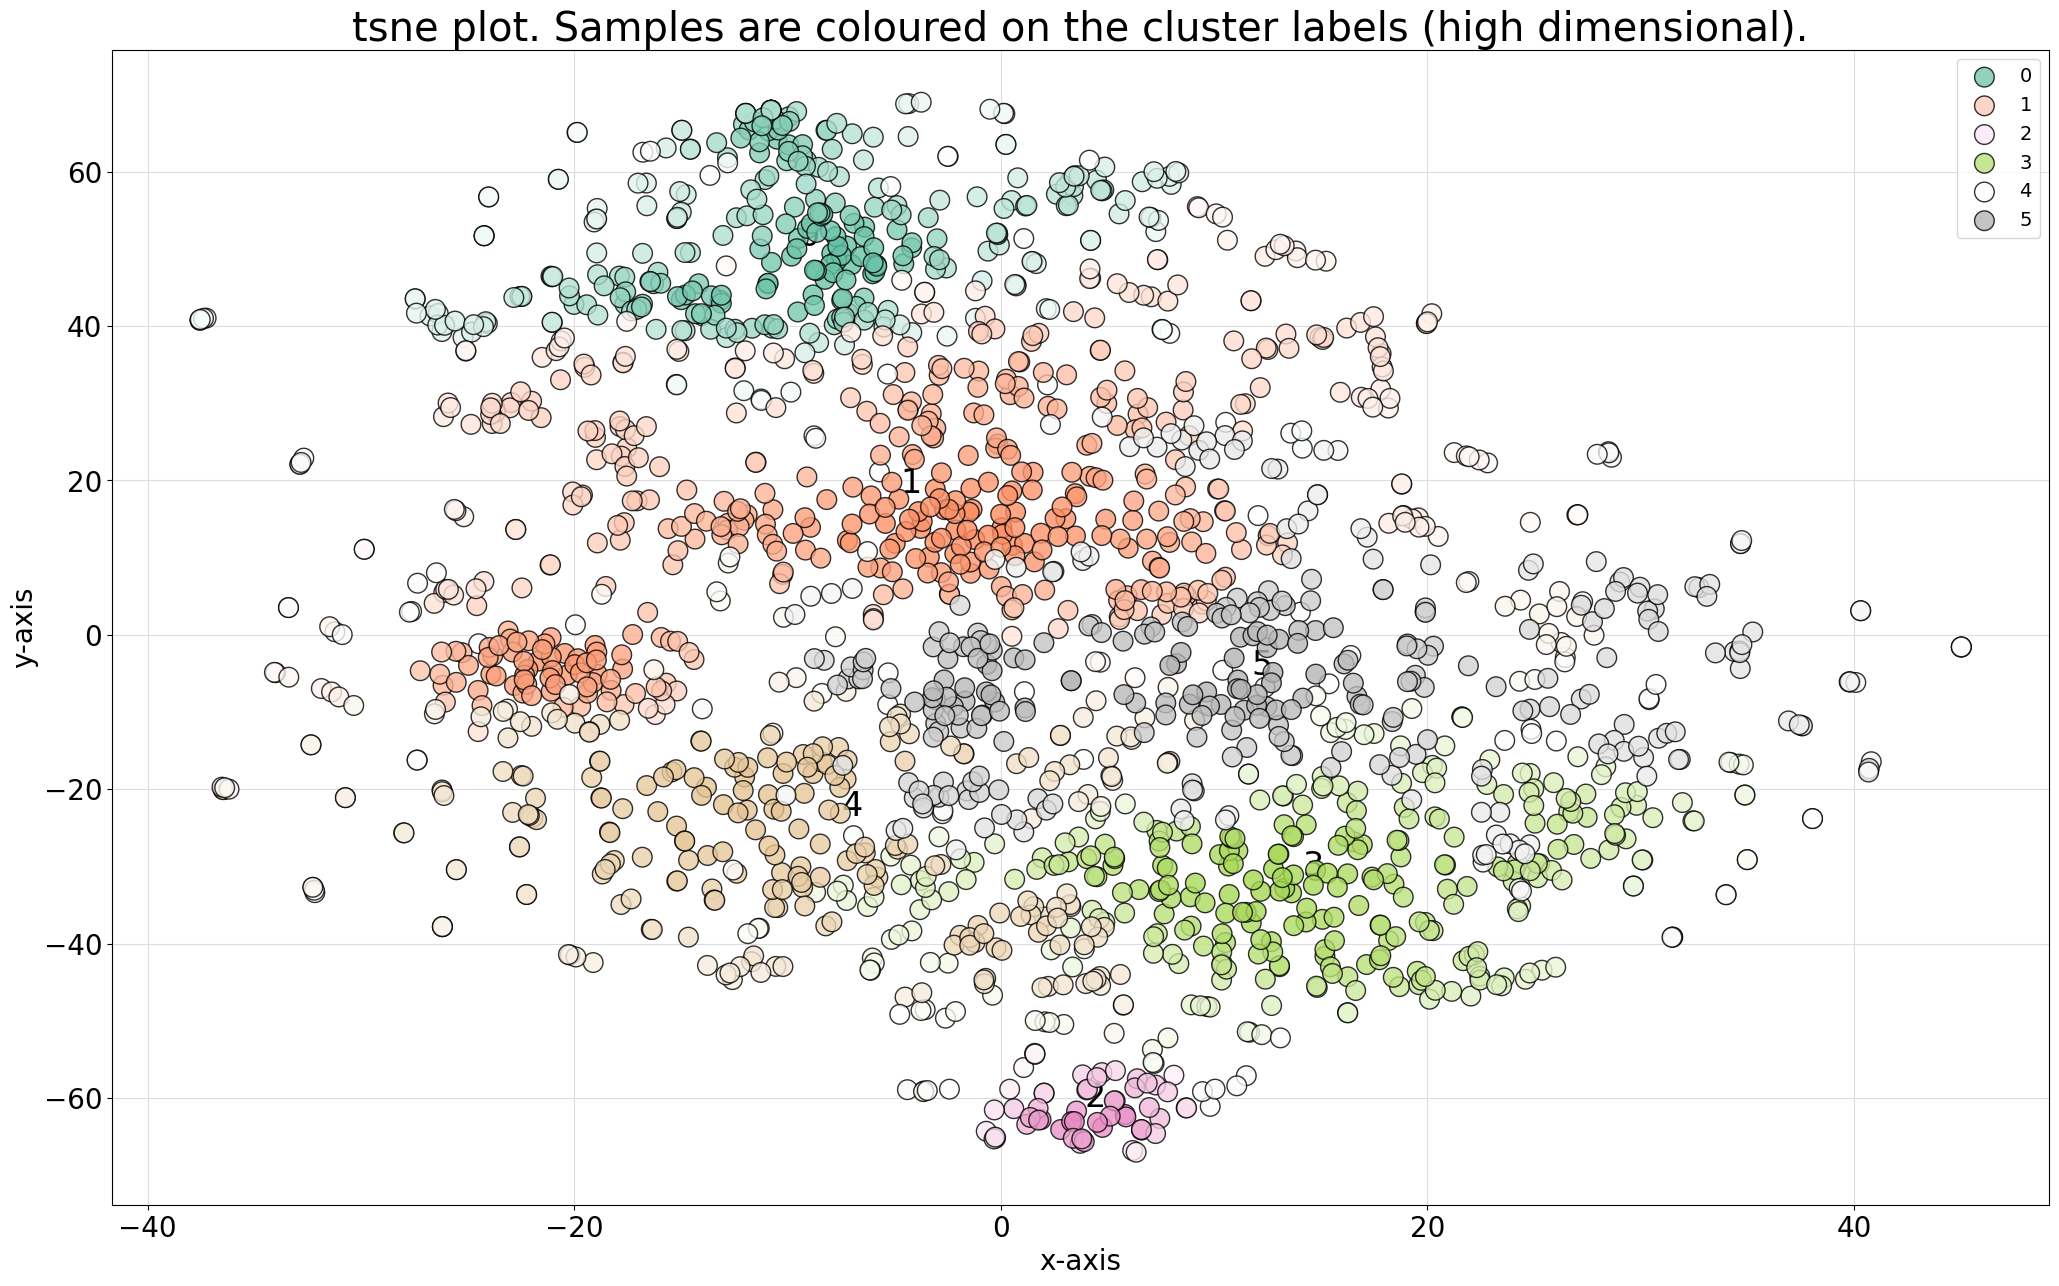

(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'tsne plot. Samples are coloured on the cluster labels (high dimensional).'}, xlabel='x-axis', ylabel='y-axis'>)

<Figure size 640x480 with 0 Axes>

In [ ]:
cl.scatter(zoom=None, dotsize=200, figsize=(25, 15), args_scatter={'fontsize':24, 'gradient':'#FFFFFF', 'cmap':'Set2', 'legend':True})

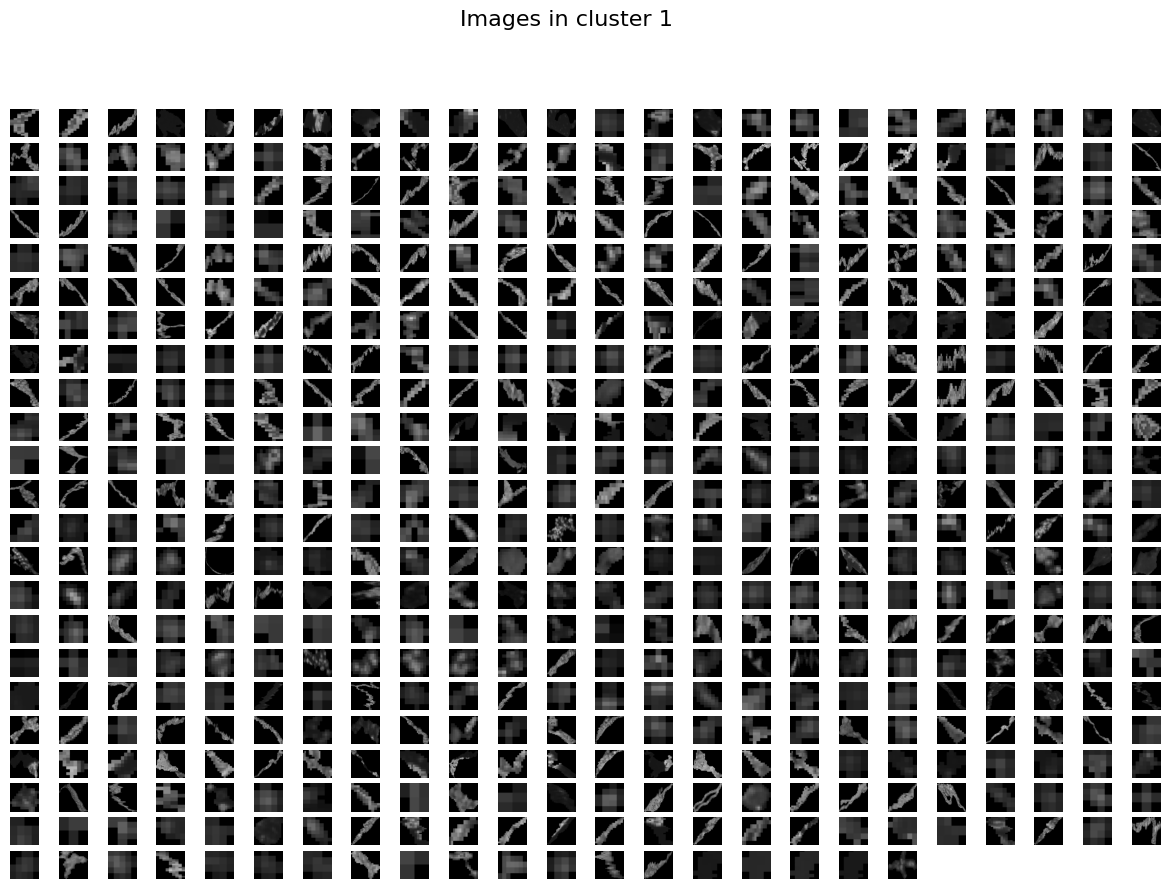

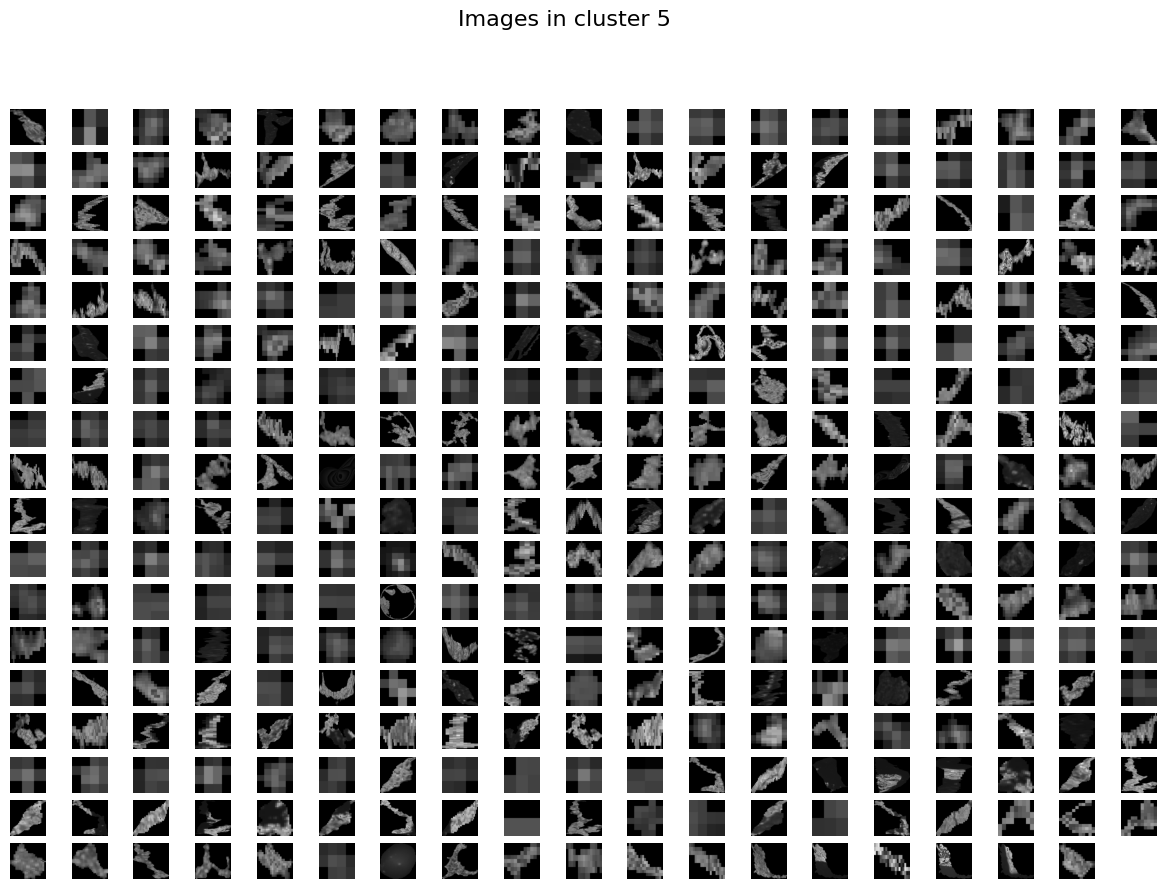

In [ ]:
cl.plot(cmap='binary', labels=[1,5])

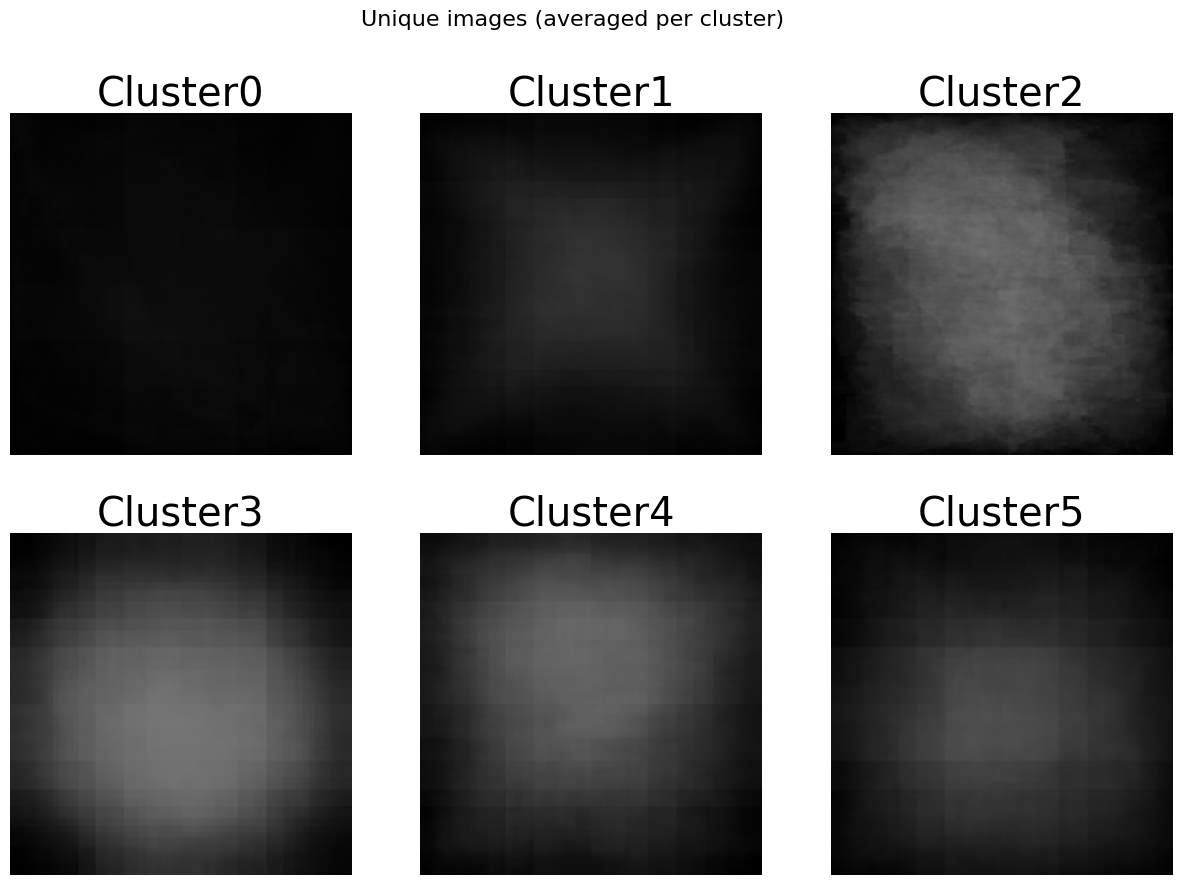

In [ ]:
cl.plot_unique()

[clustimage] >INFO> Retrieving input data set.
[clustimage] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=23952.622. Be patient now..
[clustimage] >INFO> Compute cluster labels.


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [105.0, 105.0, 123.75, 123.75],
  [95.0, 95.0, 114.375, 114.375],
  [85.0, 85.0, 104.6875, 104.6875],
  [75.0, 75.0, 94.84375, 94.84375],
  [65.0, 65.0, 84.921875, 84.921875],
  [55.0, 55.0, 74.9609375, 74.9609375],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [64.98046875, 64.98046875, 162.5, 162.5],
  [45.0, 45.0, 113.740234375, 113.740234375],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [192.5, 192.5, 223.75, 223.75],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [208.125, 208.125, 263.75, 263.75],
  [79.3701171875, 79.3701171875, 235.9375, 235.9375],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [295.0, 295.0, 312.5

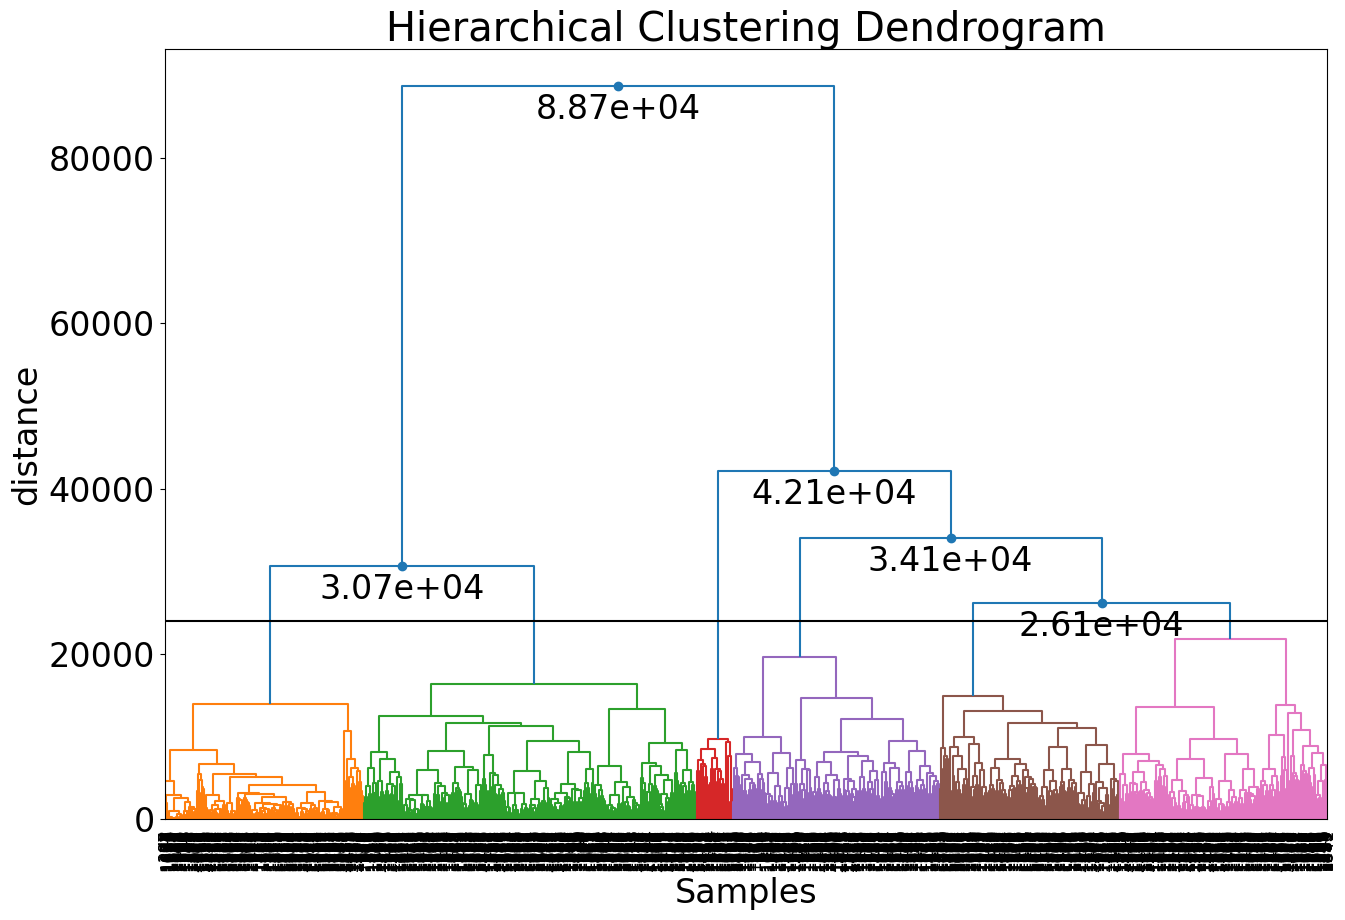

In [ ]:
cl.dendrogram()

1909
1909
Cluster 1:
/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_0.png


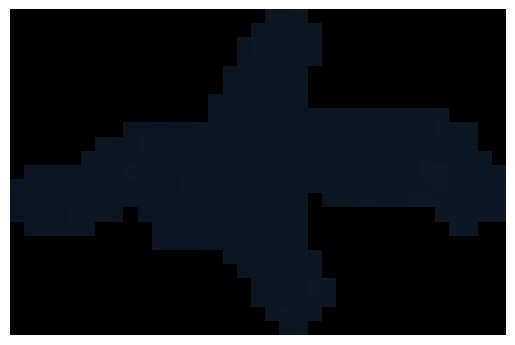

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_1.png


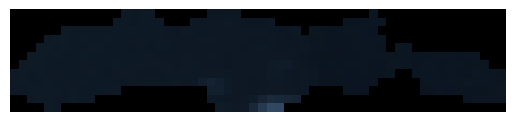

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_2.png


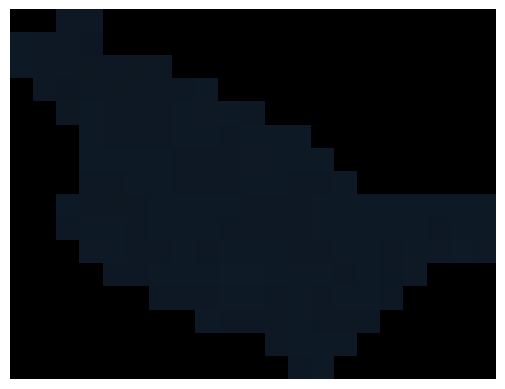

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_4.png


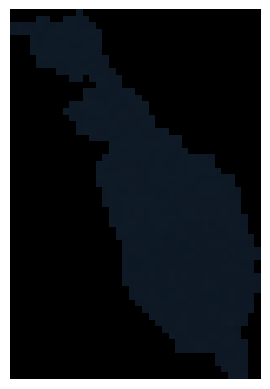

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_5.png


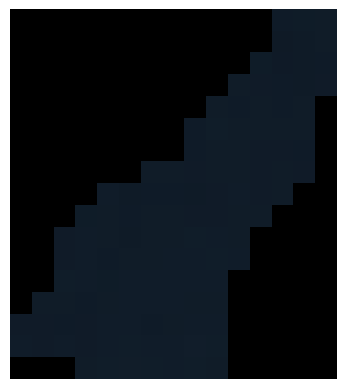

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_6.png


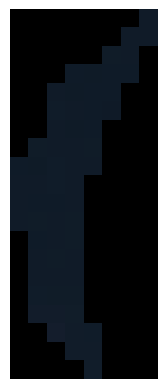

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_8.png


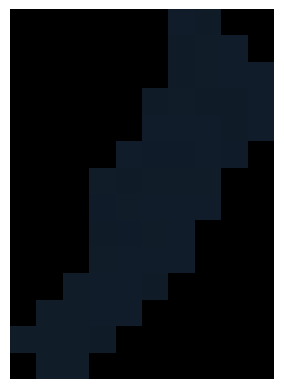

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_11.png


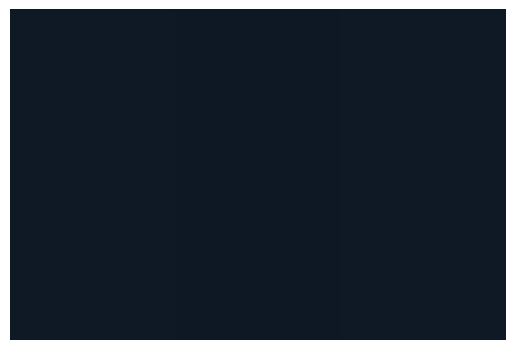

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_12.png


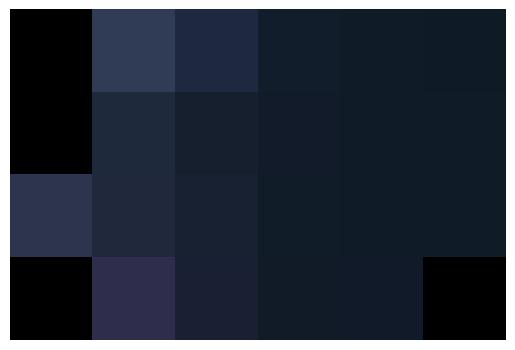

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_13.png


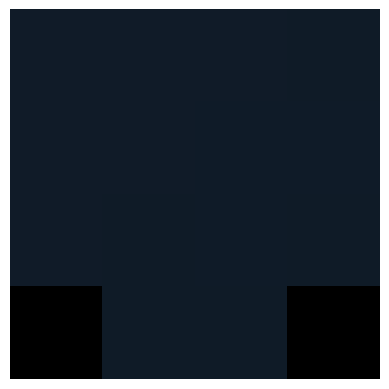

Cluster 2:
/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_6.png


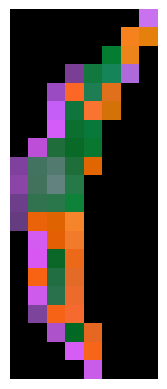

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_8.png


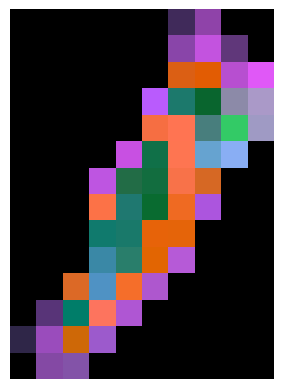

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_15.png


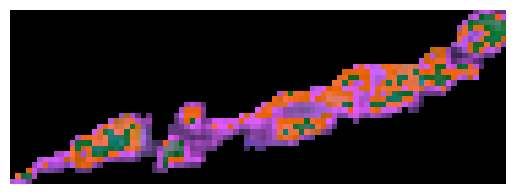

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_3.png


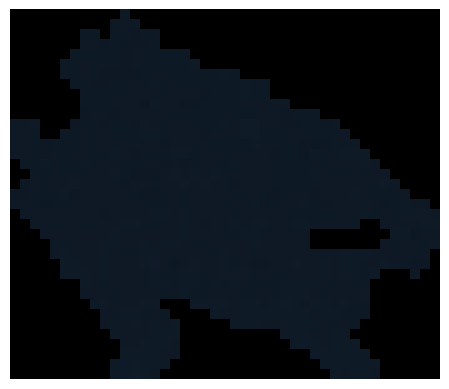

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_9.png


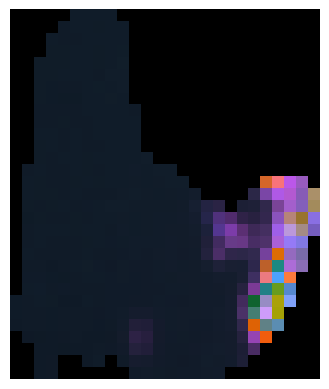

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_15.png


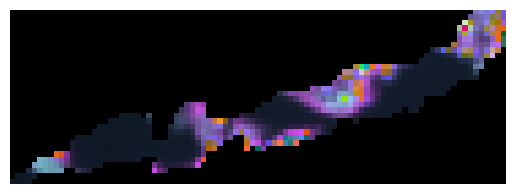

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_16.png


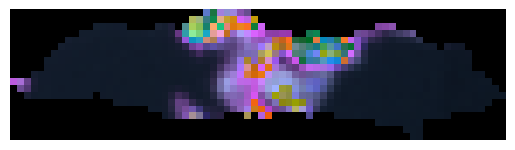

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_18.png


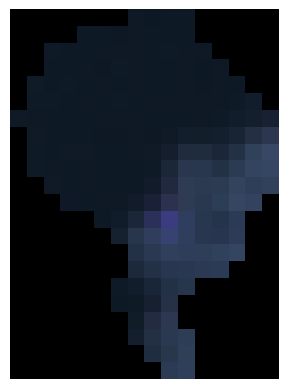

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_19.png


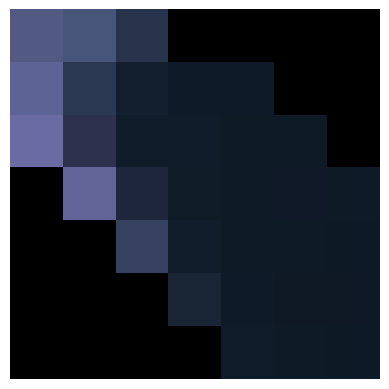

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_20.png


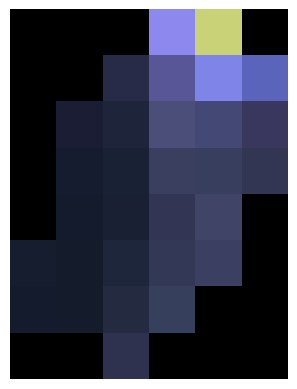

Cluster 3:
/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_7.png


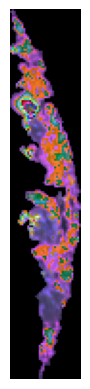

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_7.png


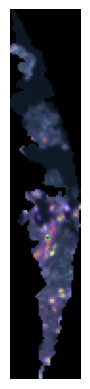

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,G]_[16045,42250]_seg_0.png


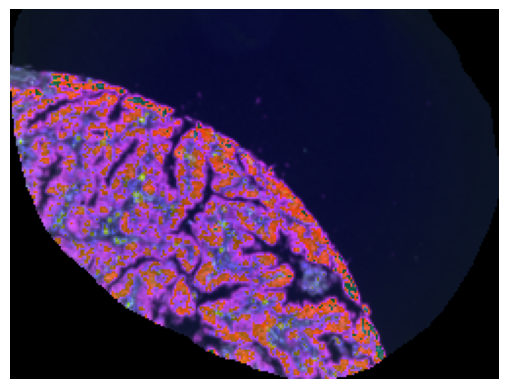

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,H]_[17997,41996]_seg_0.png


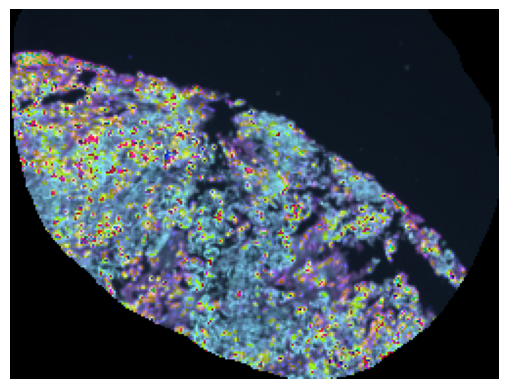

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,I]_[19855,42186]_seg_12.png


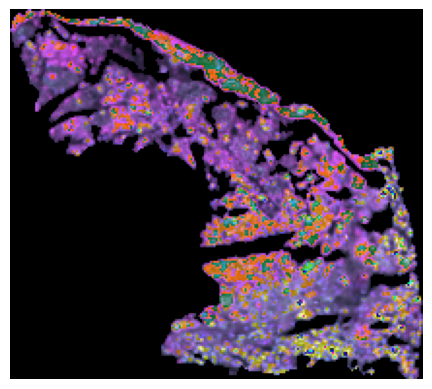

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,J]_[21712,42282]_seg_12.png


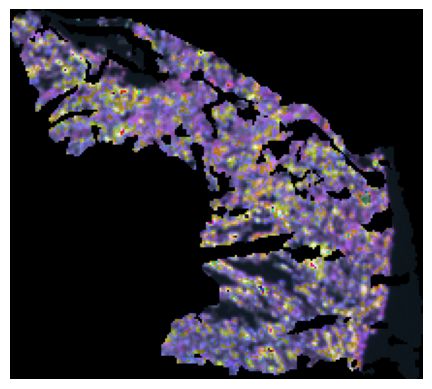

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,6,D]_[10616,43822]_seg_4.png


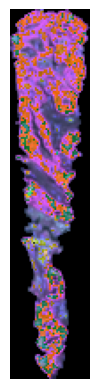

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,6,D]_[10616,43822]_seg_7.png


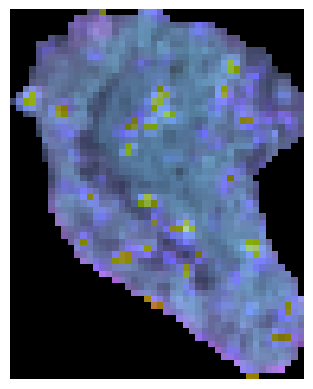

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,6,D]_[10616,43822]_seg_18.png


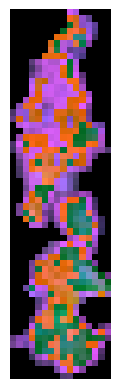

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,6,F]_[14235,44012]_seg_12.png


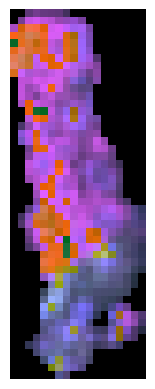

Cluster 4:
/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_3.png


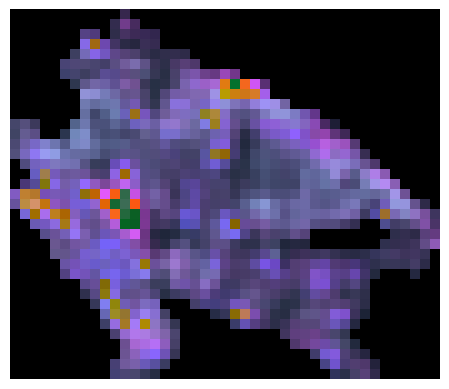

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_5.png


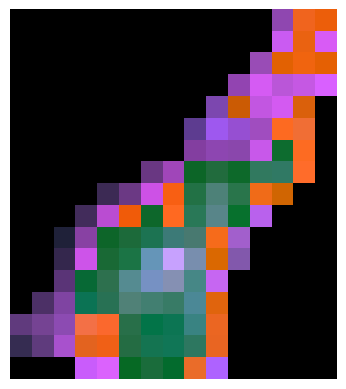

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_9.png


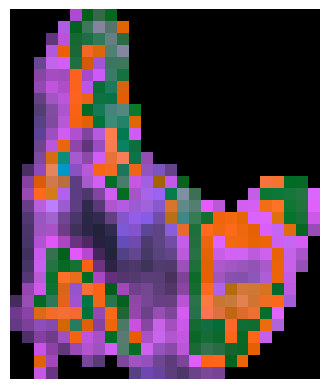

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_17.png


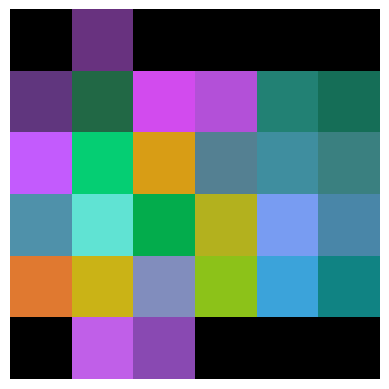

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_19.png


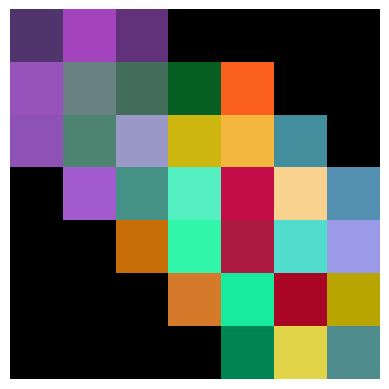

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_20.png


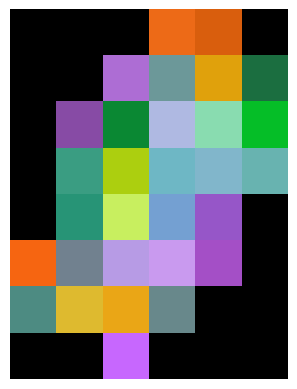

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_17.png


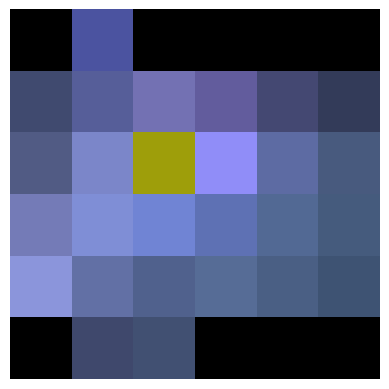

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_12.png


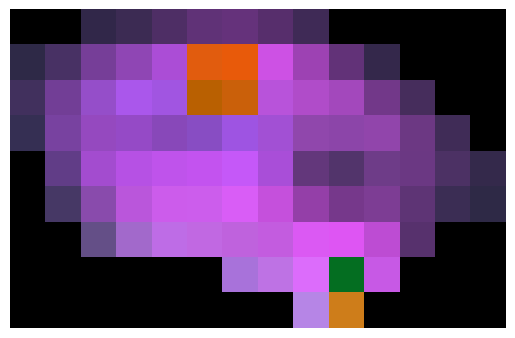

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_25.png


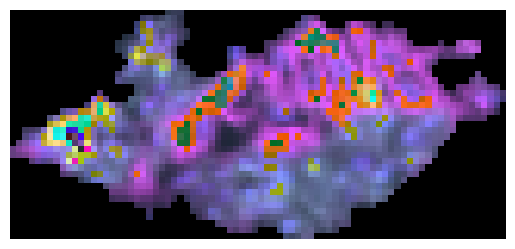

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_31.png


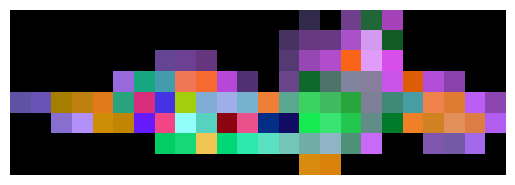

Cluster 5:
/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_10.png


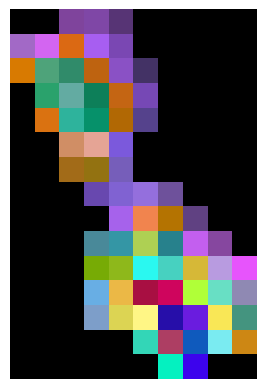

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_13.png


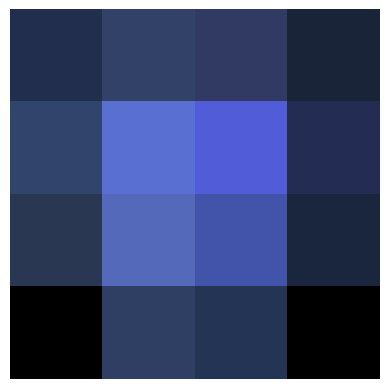

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_16.png


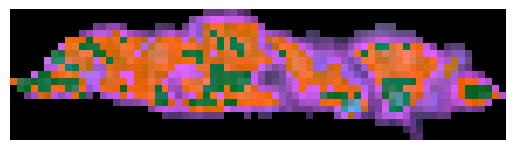

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_18.png


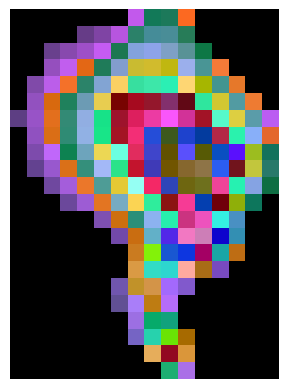

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,E]_[12425,42107]_seg_10.png


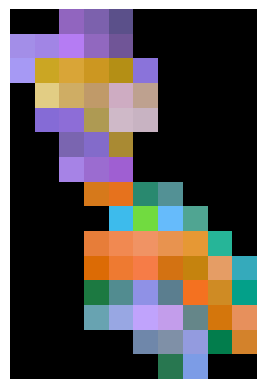

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_15.png


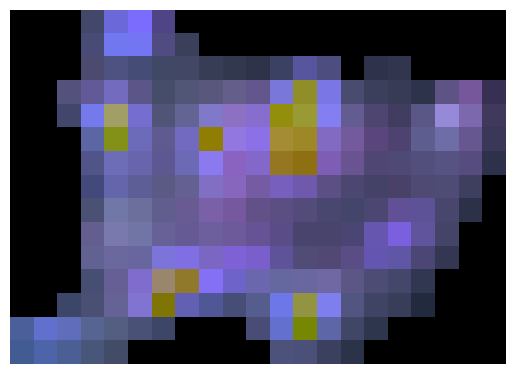

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_18.png


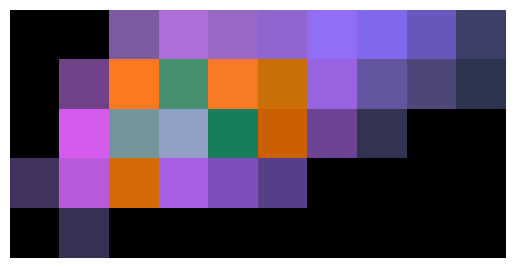

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_21.png


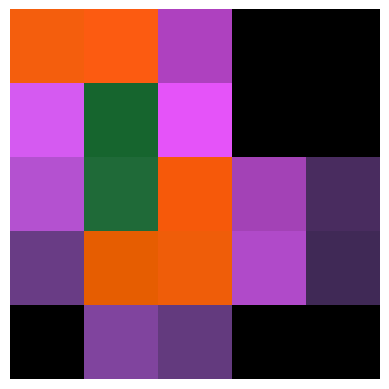

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_23.png


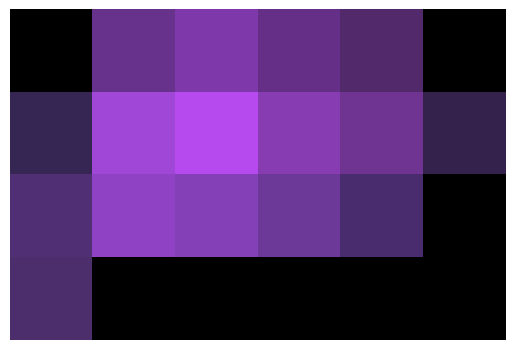

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_24.png


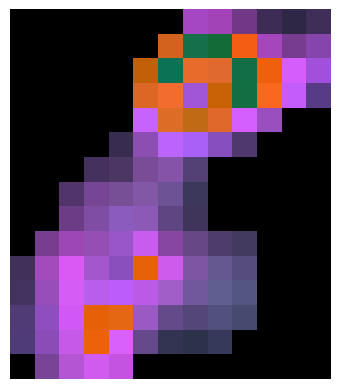

Cluster 6:
/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_4.png


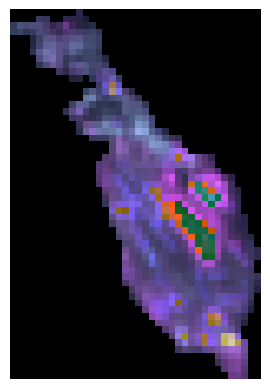

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_11.png


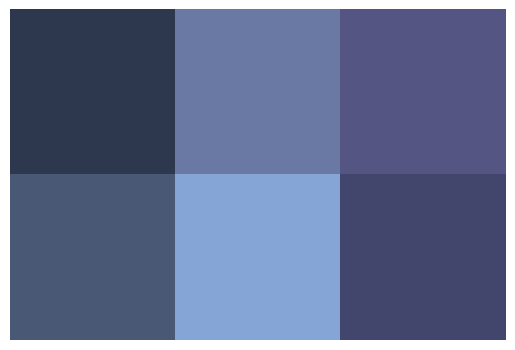

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_12.png


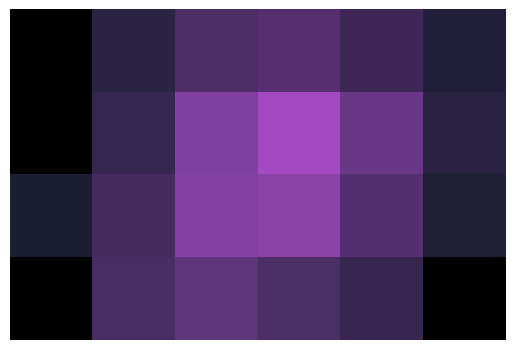

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,D]_[10616,42155]_seg_14.png


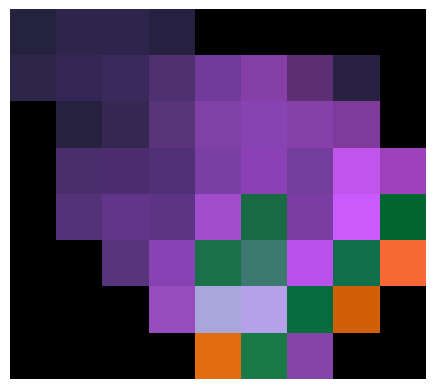

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_7.png


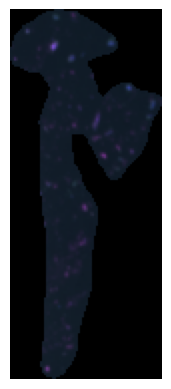

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_8.png


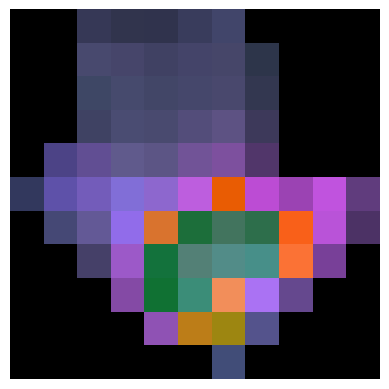

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_10.png


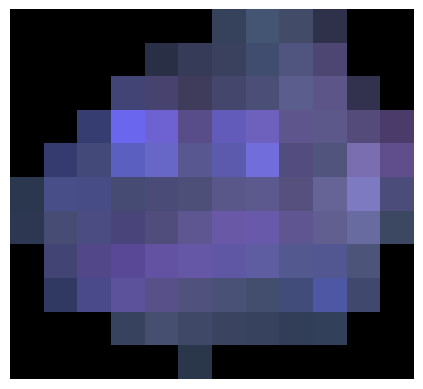

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_26.png


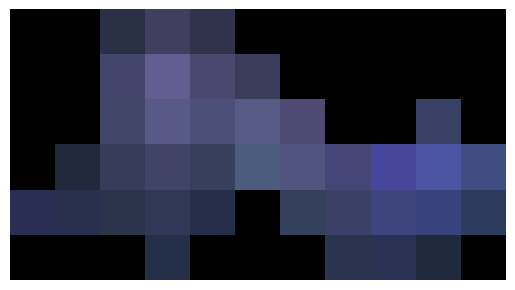

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_28.png


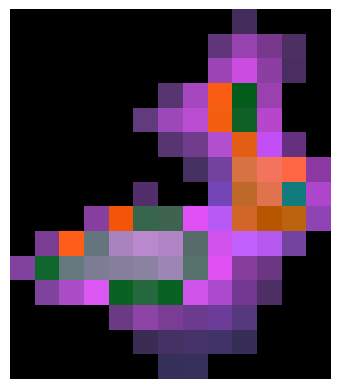

/content/drive/MyDrive/pathdata/seg_final/BOMI2_TIL_1_Core[1,5,F]_[14187,42250]_seg_32.png


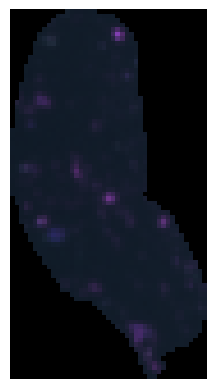

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

print(len(cl.results['pathnames']))
print(len(cl.results['labels']))

def print_images_for_clusters(pathnames, labels, cl_results):
    # Get unique cluster labels
    unique_labels = sorted(set(labels))

    # Iterate through each unique cluster label
    for label in unique_labels:
        print(f"Cluster {label}:")

        # Find indices of images belonging to the current cluster
        cluster_indices = [i for i, l in enumerate(labels) if l == label]

        # Select up to 10 images for display
        num_images_to_display = min(10, len(cluster_indices))

        for i in range(num_images_to_display):
            # Load and display the image
            image_path = pathnames[cluster_indices[i]]
            print(image_path)
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.axis('off')
            plt.show()

# Example usage:
print_images_for_clusters(cl.results['pathnames'], cl.results['labels'], cl.results)


In [ ]:
https://www.researchgate.net/publication/373163948_Automated_Semiconductor_Defect_Inspection_in_Scanning_Electron_Microscope_Images_a_Systematic_Review